### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 08 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 08 декабря, -4 балла после 08:30 15 декабря, -6 баллов после 08:30 22 декабря, -8 баллов после 08:30 29 декабря.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [389]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree

from collections import defaultdict

In [390]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        self.feature_importance = defaultdict(int)
        
    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        right_mask = x[:, feature_id] > threshold
        left_mask = ~right_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        # Ваш код здесь
        imputity_func = {
            'class_error' : lambda x, y: 1 - np.max(x / y, axis=1, keepdims=True),
            'gini' : lambda x, y : 1 - np.sum((x / y)**2, axis=1, keepdims=True),
            'entropy' : lambda x, y : -np.sum((x / y) * np.log(x / y), axis=1, keepdims=True)
        }
        best_gain = -1000
        best_feature_id = -1
        best_thr = -1
            
        mid_classes = np.bincount(y, minlength=self.num_class)
        mid_total = mid_classes.sum()
        if self.criterion == 'class_error':
            mid_impurity = 1 - np.max(mid_classes / mid_total)
        elif self.criterion == 'gini':
            mid_impurity = 1 - np.sum((mid_classes / mid_total)**2)
        elif self.criterion == 'entropy':
            mid_impurity = 1 - np.sum((mid_classes / mid_total) * np.log(mid_classes / mid_total))
        
        for f_id in range(x.shape[1]):
            f_classes = y.copy()
            f_values =  x[:, f_id]
            sort_order = np.argsort(f_values)
            f_classes = f_classes[sort_order]
            f_values = f_values[sort_order]
            
            border_cnts = None
            cur_cnt = np.zeros((self.num_class, ))
            thrs = []
            for ind in range(f_values.shape[0]):
                if ind < 1:
                    cur_cnt[f_classes[ind]] += 1
                    continue
            
                if f_classes[ind] != f_classes[ind - 1] and f_values[ind] != f_values[ind - 1]:
                    if border_cnts is None:
                        border_cnts = cur_cnt[np.newaxis, :].copy()
                    else:
                        border_cnts = np.r_[border_cnts, cur_cnt[np.newaxis, :]]
                    thrs.append((f_values[ind] + f_values[ind - 1]) / 2)
                cur_cnt[f_classes[ind]] += 1
                
            if border_cnts is None:
                continue
            
            left_cnts = border_cnts
            left_total = left_cnts.sum(axis=1, keepdims=True)
            right_cnts = cur_cnt - left_cnts
            right_total = right_cnts.sum(axis=1, keepdims=True)
            
            left_impurity = imputity_func[self.criterion](left_cnts, left_total)
            right_impurity = imputity_func[self.criterion](right_cnts, right_total)
            
            gains = (mid_impurity - left_total/mid_total * left_impurity - right_total/mid_total * right_impurity).reshape(-1)

            max_ind = gains.argmax()
            if gains[max_ind] > best_gain:
                best_gain = gains[max_ind]
                best_feature_id = f_id
                best_thr = thrs[max_ind]
                
        if best_feature_id == -1:
            return None, None, None
        return best_feature_id, best_thr, best_gain

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # Ваш код здесь
#         print(f"id = {node_id}, samples = {x.shape[0]}, counts = {np.bincount(y, minlength=self.num_class)}")
        if depth > self.max_depth or x.shape[0] < self.min_samples_split or np.unique(y).shape[0] == 1:
            
            classes = np.bincount(y, minlength=self.num_class)
            probs = classes / classes.sum()
#             print(f"LEAF_1: class = {probs.argmax()}, prob = {probs.max()}")
            self.tree[node_id] = (self.LEAF_TYPE, probs.argmax(), probs.max())
        else:
            
            f_id, thr, gain = self.__find_threshold(x, y)
            if f_id is None:
                classes = np.bincount(y, minlength=self.num_class)
                probs = classes / classes.sum()
#                 print(f"LEAF_2: class = {probs.argmax()}, prob = {probs.max()}")
                self.tree[node_id] = (self.LEAF_TYPE, probs.argmax(), probs.max())
            else:
                self.feature_importance[f_id] += x.shape[0] / self.dataset_len * gain
                x_left, x_right, y_left, y_right = self.__div_samples(x, y, f_id, thr)
#                 print(f"NONE_LEAF: feature = {f_id}, thr = {thr}")
                self.tree[node_id] = (self.NON_LEAF_TYPE, f_id, thr)
                self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
                self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.dataset_len = x.shape[0]
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 
        return self
        
    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 2)
            else:
                return self.__predict_class(x, 2 * node_id + 1)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        # Ваш код здесь
        f_imps = list(self.feature_importance.items())
        f_imps = sorted(f_imps, key=lambda x: x[1], reverse=True)[:10]
        return f_imps
#         pass

In [391]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)
# ty = np.array([3, 3, 0, 2, 1, 0, 0, 0])
# tx = np.array([[0.75], [0.7], [0.5], [0.35], [0.3], [0.2], [0.15], [0.1]])
# print(tx.shape)
# my_clf.num_class = 4
# my_clf._find_threshold(tx, ty)

In [392]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

[Text(167.4, 190.26, 'X[12] <= 755.0\ngini = 0.658\nsamples = 160\nvalue = [53, 64, 43]'),
 Text(83.7, 135.9, 'X[9] <= 4.85\ngini = 0.495\nsamples = 100\nvalue = [2, 60, 38]'),
 Text(41.85, 81.53999999999999, 'X[6] <= 0.545\ngini = 0.176\nsamples = 63\nvalue = [2, 57, 4]'),
 Text(20.925, 27.180000000000007, '\n  (...)  \n'),
 Text(62.775000000000006, 27.180000000000007, '\n  (...)  \n'),
 Text(125.55000000000001, 81.53999999999999, 'X[10] <= 0.91\ngini = 0.149\nsamples = 37\nvalue = [0, 3, 34]'),
 Text(104.625, 27.180000000000007, '\n  (...)  \n'),
 Text(146.475, 27.180000000000007, '\n  (...)  \n'),
 Text(251.10000000000002, 135.9, 'X[6] <= 2.165\ngini = 0.266\nsamples = 60\nvalue = [51, 4, 5]'),
 Text(209.25, 81.53999999999999, 'X[9] <= 3.605\ngini = 0.408\nsamples = 7\nvalue = [0, 2, 5]'),
 Text(188.32500000000002, 27.180000000000007, '\n  (...)  \n'),
 Text(230.175, 27.180000000000007, '\n  (...)  \n'),
 Text(292.95, 81.53999999999999, 'X[4] <= 135.5\ngini = 0.073\nsamples = 53\nva

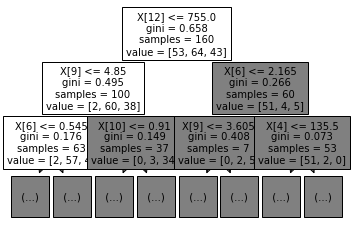

In [393]:
clf = clf.fit(X_train, y_train)
plot_tree(clf, max_depth = 2, fontsize=10)

In [394]:
my_clf = my_clf.fit(X_train, y_train)

In [395]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
 

0.8888888888888888
0.8888888888888888


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [396]:
%time clf.fit(X_train, y_train)

Wall time: 1e+03 µs


DecisionTreeClassifier()

In [397]:
%time my_clf.fit(X_train, y_train)

Wall time: 35 ms


Не вышло😐...

## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [398]:
df = pd.read_csv('./speed-dating-experiment/Speed Dating Data.csv', encoding='latin1')

In [399]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Data columns (total 195 columns):
 #   Column    Dtype  
---  ------    -----  
 0   iid       int64  
 1   id        float64
 2   gender    int64  
 3   idg       int64  
 4   condtn    int64  
 5   wave      int64  
 6   round     int64  
 7   position  int64  
 8   positin1  float64
 9   order     int64  
 10  partner   int64  
 11  pid       float64
 12  match     int64  
 13  int_corr  float64
 14  samerace  int64  
 15  age_o     float64
 16  race_o    float64
 17  pf_o_att  float64
 18  pf_o_sin  float64
 19  pf_o_int  float64
 20  pf_o_fun  float64
 21  pf_o_amb  float64
 22  pf_o_sha  float64
 23  dec_o     int64  
 24  attr_o    float64
 25  sinc_o    float64
 26  intel_o   float64
 27  fun_o     float64
 28  amb_o     float64
 29  shar_o    float64
 30  like_o    float64
 31  prob_o    float64
 32  met_o     float64
 33  age       float64
 34  field     object 
 35  field_cd  float64
 36  undergra  obj

In [400]:
# Удаляем полную дичь
df = df.iloc[:, :97]

In [401]:
df.iid.nunique()

551

In [402]:
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)

In [403]:
df.drop_duplicates(subset=['iid']).gender.value_counts()

1    277
0    274
Name: gender, dtype: int64

In [404]:
df.drop_duplicates(subset=['iid']).condtn.value_counts()
df = df.drop(['condtn'], axis=1)

In [405]:
df.wave.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21], dtype=int64)

In [406]:
df = df.drop(['position', 'positin1'], axis=1)

In [407]:
df = df.drop(['order'], axis=1)

In [408]:
# Что такое pf_o_sin, этого даже в описании нет...
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)

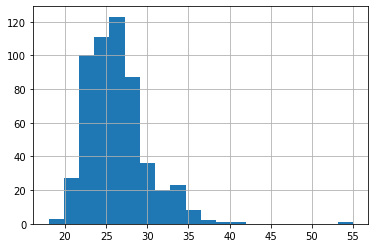

In [409]:
df.drop_duplicates(subset=['iid']).age.hist(bins=20)
df.drop_duplicates('iid').age.isnull().sum()
df = df.dropna(subset=['age'])

In [410]:
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df = df.drop(['field'], axis=1)

In [411]:
df['field_cd']

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
8373    18.0
8374    18.0
8375    18.0
8376    18.0
8377    18.0
Name: field_cd, Length: 8283, dtype: float64

In [412]:
df = pd.concat([df.drop(['field_cd'], axis=1), pd.get_dummies(df['field_cd'], prefix='field_cd')], axis=1)
df.head()

,iid,gender,wave,round,partner,pid,match,int_corr,samerace,age,...,field_cd_10.0,field_cd_11.0,field_cd_12.0,field_cd_13.0,field_cd_14.0,field_cd_15.0,field_cd_16.0,field_cd_17.0,field_cd_18.0,field_cd_19.0
0,1,0,1,10,1,11.0,0,0.14,0,21.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,10,2,12.0,0,0.54,0,21.0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,10,3,13.0,1,0.16,1,21.0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,10,4,14.0,1,0.61,0,21.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,10,5,15.0,1,0.21,0,21.0,...,0,0,0,0,0,0,0,0,0,0


In [413]:
df = df.drop(['undergra'], axis=1)

In [414]:
# Дропай дропай, мы же богатые, ещё найдем признаков
df = df.drop(['mn_sat', 'tuition'], axis=1)

#Сама раса нам не нужна, потому что дальше мы будем смотреть, насколько важно совпадение.
df = df.drop(['race'], axis=1)

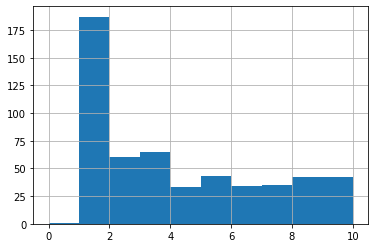

In [415]:
df.drop_duplicates('iid').imprace.dropna().hist()

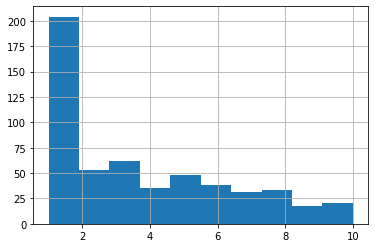

In [416]:
df.drop_duplicates('iid').imprelig.dropna().hist()

In [417]:
# Оставим как есть, добрые признаки
df = df.dropna(subset=['imprelig', 'imprace'])

In [418]:
df = df.drop(['from', 'zipcode'], axis=1)

In [419]:
df = df.drop(['income'], axis=1)

In [420]:
# goal можно оставить как есть, думаю будет работать неплохо.
df = df.dropna(subset=['goal'])
# go out и date удалим, кажется они какие-то бесполезные
df = df.drop(['go_out', 'date'], axis=1)

In [421]:
df = df.drop(['career'], axis=1)
df = pd.concat([df.drop(['career_c'], axis=1), pd.get_dummies(df['career_c'], prefix='career_c')], axis=1)
df.head()

,iid,gender,wave,round,partner,pid,match,int_corr,samerace,age,...,career_c_8.0,career_c_9.0,career_c_10.0,career_c_11.0,career_c_12.0,career_c_13.0,career_c_14.0,career_c_15.0,career_c_16.0,career_c_17.0
0,1,0,1,10,1,11.0,0,0.14,0,21.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,10,2,12.0,0,0.54,0,21.0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,10,3,13.0,1,0.16,1,21.0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,10,4,14.0,1,0.61,0,21.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,10,5,15.0,1,0.21,0,21.0,...,0,0,0,0,0,0,0,0,0,0


In [422]:
df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)

In [423]:
# Какие-то бесполезные признаки.
df = df.drop(['exphappy', 'expnum'], axis=1)

In [424]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

In [425]:
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

In [426]:
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)

In [427]:

df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [428]:
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

df = df.drop(['temp_totalsum'], axis=1)

In [429]:
for i in [3, 4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

In [430]:
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'

In [431]:
df_male['pid'] = df_male['pid'].astype(int)
print(df_male.shape)
print(df_male['pid'])
df_male.head()

(4087, 60)
100       1
101       2
102       3
103       4
104       5
       ... 
8373    526
8374    527
8375    528
8376    529
8377    530
Name: pid, Length: 4087, dtype: int32


,iid,wave,round,partner,pid,match,int_corr,samerace,age,imprace,...,career_c_8.0,career_c_9.0,career_c_10.0,career_c_11.0,career_c_12.0,career_c_13.0,career_c_14.0,career_c_15.0,career_c_16.0,career_c_17.0
100,11,1,10,1,1,0,0.14,0,27.0,7.0,...,0,0,0,0,0,0,0,0,0,0
101,11,1,10,2,2,0,0.29,1,27.0,7.0,...,0,0,0,0,0,0,0,0,0,0
102,11,1,10,3,3,0,-0.24,1,27.0,7.0,...,0,0,0,0,0,0,0,0,0,0
103,11,1,10,4,4,0,-0.18,1,27.0,7.0,...,0,0,0,0,0,0,0,0,0,0
104,11,1,10,5,5,0,-0.43,1,27.0,7.0,...,0,0,0,0,0,0,0,0,0,0


In [432]:
print(df_female.shape)
print(df_female['iid_f'])
df_female.head()

(267, 57)
0         1
10        2
20        3
30        4
40        5
       ... 
7762    525
7784    526
7806    527
7850    529
7872    530
Name: iid_f, Length: 267, dtype: int64


,iid_f,wave_f,round_f,partner_f,pid_f,age_f,imprace_f,imprelig_f,goal_f,attr1_1_f,...,career_c_8.0_f,career_c_9.0_f,career_c_10.0_f,career_c_11.0_f,career_c_12.0_f,career_c_13.0_f,career_c_14.0_f,career_c_15.0_f,career_c_16.0_f,career_c_17.0_f
0,1,1,10,1,11.0,21.0,2.0,4.0,2.0,15.0,...,0,0,0,0,0,0,0,0,0,0
10,2,1,10,1,11.0,24.0,2.0,5.0,1.0,45.0,...,0,0,0,0,0,0,0,0,0,0
20,3,1,10,1,11.0,25.0,8.0,4.0,6.0,35.0,...,0,0,0,0,0,0,0,0,0,0
30,4,1,10,1,11.0,23.0,1.0,1.0,1.0,20.0,...,0,0,0,0,0,0,0,0,0,0
40,5,1,10,1,11.0,21.0,8.0,1.0,2.0,20.0,...,0,0,0,0,0,0,0,0,0,0


In [433]:
final_df = pd.merge(df_male, df_female, left_on=['pid'], right_on=['iid_f'])


In [434]:
y = final_df['match'].values
y.shape

(4043,)

In [435]:
final_df = final_df.drop(['match', 'iid', 'wave', 'round', 'partner','pid', 'iid_f', 'wave_f', 'round_f', 'partner_f', 'pid_f'], axis=1)
final_df.head()

,int_corr,samerace,age,imprace,imprelig,goal,attr1_1,sinc1_1,intel1_1,fun1_1,...,career_c_8.0_f,career_c_9.0_f,career_c_10.0_f,career_c_11.0_f,career_c_12.0_f,career_c_13.0_f,career_c_14.0_f,career_c_15.0_f,career_c_16.0_f,career_c_17.0_f
0,0.14,0,27.0,7.0,3.0,1.0,35.0,20.0,20.0,20.0,...,0,0,0,0,0,0,0,0,0,0
1,0.54,0,22.0,1.0,1.0,1.0,60.0,0.0,0.0,40.0,...,0,0,0,0,0,0,0,0,0,0
2,0.16,1,22.0,3.0,5.0,2.0,19.0,18.0,19.0,18.0,...,0,0,0,0,0,0,0,0,0,0
3,0.61,0,23.0,1.0,1.0,2.0,30.0,5.0,15.0,40.0,...,0,0,0,0,0,0,0,0,0,0
4,0.21,0,24.0,3.0,1.0,1.0,30.0,10.0,20.0,10.0,...,0,0,0,0,0,0,0,0,0,0


In [436]:
X = final_df.values
# print(sorted(list(X[:, 10])))
X.shape

(4043, 106)

In [437]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [438]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [439]:
%time clf = clf.fit(X_tr, y_tr)

Wall time: 46 ms


[Text(167.4, 190.26, 'X[61] <= 19.075\ngini = 0.281\nsamples = 3234\nvalue = [2687, 547]'),
 Text(83.7, 135.9, 'X[66] <= 16.513\ngini = 0.24\nsamples = 1875\nvalue = [1613, 262]'),
 Text(41.85, 81.53999999999999, 'X[67] <= 31.411\ngini = 0.216\nsamples = 1456\nvalue = [1277, 179]'),
 Text(20.925, 27.180000000000007, '\n  (...)  \n'),
 Text(62.775000000000006, 27.180000000000007, '\n  (...)  \n'),
 Text(125.55000000000001, 81.53999999999999, 'X[94] <= 0.5\ngini = 0.318\nsamples = 419\nvalue = [336, 83]'),
 Text(104.625, 27.180000000000007, '\n  (...)  \n'),
 Text(146.475, 27.180000000000007, '\n  (...)  \n'),
 Text(251.10000000000002, 135.9, 'X[11] <= 8.165\ngini = 0.331\nsamples = 1359\nvalue = [1074, 285]'),
 Text(209.25, 81.53999999999999, 'X[11] <= 5.278\ngini = 0.398\nsamples = 452\nvalue = [328, 124]'),
 Text(188.32500000000002, 27.180000000000007, '\n  (...)  \n'),
 Text(230.175, 27.180000000000007, '\n  (...)  \n'),
 Text(292.95, 81.53999999999999, 'X[42] <= 0.5\ngini = 0.292\ns

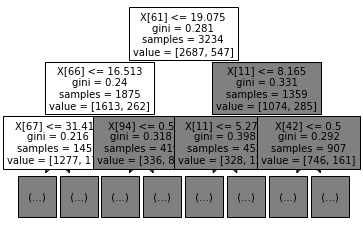

In [440]:
plot_tree(clf, max_depth = 2, fontsize=10)

In [441]:
%time my_clf =  my_clf.fit(X_tr, y_tr)

Wall time: 2.85 s


In [442]:
print("acc_sklearn = ", accuracy_score(y_pred=clf.predict(X_val), y_true=y_val))
print("acc_mine = ",accuracy_score(y_pred=my_clf.predict(X_val), y_true=y_val))
print("f1_sklearn = ", f1_score(y_pred=clf.predict(X_val), y_true=y_val))
print("f1_mine = ",f1_score(y_pred=my_clf.predict(X_val), y_true=y_val))

acc_sklearn =  0.7416563658838071
acc_mine =  0.8355995055624228
f1_sklearn =  0.22304832713754646
f1_mine =  0.21301775147928992


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [443]:
kf = KFold(n_splits=5)
accs = []
criters = ('class_error', 'gini', 'entropy')
crit_acc = {}
for crit in criters:
    my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion=crit)
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        fitted = my_clf.fit(X_train, y_train)
        my_y = fitted.predict(X_val)
        accs.append(accuracy_score(my_y, y_val))
    crit_acc[crit] = sum(accs) / len(accs)

<ipython-input-390-b370b9acbdc5>:48: RuntimeWarning: divide by zero encountered in log
  'entropy' : lambda x, y : -np.sum((x / y) * np.log(x / y), axis=1, keepdims=True)
<ipython-input-390-b370b9acbdc5>:48: RuntimeWarning: invalid value encountered in multiply
  'entropy' : lambda x, y : -np.sum((x / y) * np.log(x / y), axis=1, keepdims=True)


In [444]:
crit_acc

{'class_error': 0.8236430503371721,
 'gini': 0.8205503677685444,
 'entropy': 0.8160573906587197}

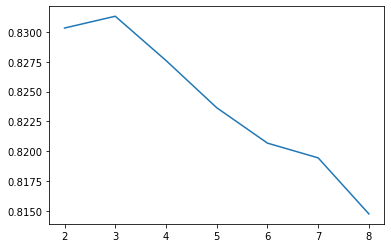

In [445]:
kf = KFold(n_splits=5)

max_depths = (2,3,4,5,6,7,8)
dept_acc = []
for dept in max_depths:
    my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion='class_error', max_depth=dept)
    accs = []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        fitted = my_clf.fit(X_train, y_train)
        my_y = fitted.predict(X_val)
        accs.append(accuracy_score(my_y, y_val))
    dept_acc.append(sum(accs) / len(accs))
plt.plot(max_depths, dept_acc)

Получается, что лучший критерий - ошибка классификации, но выделяется он не сильно. 

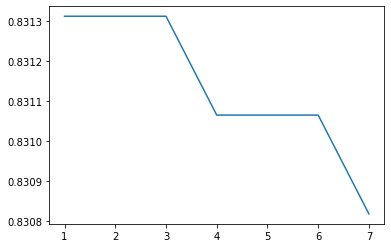

In [446]:
kf = KFold(n_splits=5)

min_splits = (1,2,3,4,5,6,7)
spl_acc = []
for spl in min_splits:
    my_clf = MyDecisionTreeClassifier(min_samples_split=spl, criterion='class_error', max_depth=3)
    accs = []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        fitted = my_clf.fit(X_train, y_train)
        my_y = fitted.predict(X_val)
        accs.append(accuracy_score(my_y, y_val))
    spl_acc.append(sum(accs) / len(accs))
plt.plot(min_splits, spl_acc)

Ну максимальная точность на кросс-валидации получилась 0.8313, roc-auc я трогать не буду, пусть лежит отдыхает.

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

Тут поставил джини, потому что у других очень маленькая важность получается (нормировать не хочу)

In [447]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion='gini', max_depth=3)

In [448]:
my_clf =  my_clf.fit(X, y)

In [449]:
important_features = my_clf.get_feature_importance()
# print(important_features)

In [450]:
for f, imp in important_features:
    print(f"{final_df.columns[f]} = {imp}")

fun1_1_f = 0.004107801760524367
fun1_1 = 0.004101826208742054
sinc2_1 = 0.0020617231880294155
imprelig_f = 0.0017107249333044195
fun2_1_f = 0.0013482310927630885
attr1_1_f = 0.0012724470403017495
int_corr = 0.0009320815321415039
career_c_2.0 = 0.000791491466732624
intel2_1_f = 0.0007064642098900118
attr2_1 = 0.0004758034424006938


Весёлость, религия, привлекательность. В принципе похоже на правду.

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### ВАШ ОТЗЫВ ЗДЕСЬ



1. Понятно, что работать не хуже, чем библиотечная функция это хорошо. Но когда в них используются какие-то преколы типа усреднения порога, то это не всегда бывает очевидно (я даже почитал документацию, но там вообще мрак...). Поэтому лучше такие моменты писать куда-нибудь в описание задачи.

2. Задания со скоростью работы это вообще...<br>
   Вроде бы х10 от времени библиотечной функции это много, но есть ощущение, что эта цифра привязана к конкретному авторскому решению. И получается, что приходится его угадывать (я серьезно пытался). <br>
   Но даже если угадать это решение(конечно же озарение), то тут начинается дичь с реализацией. Да, я не спорю, точно не пишу лучший код. Но когда авторское решение с другой релизацией медленнее в 5 раз, приходит осознание, что требуется конкретная реализация  (потому что в документации sklearn как известно дичь и там идей не подсмотреть). Короче я хотел сказать, что брать хорошее авторское решение и требовать повторить его время, это не лучшая идея.
   Покритиковал, теперь время предложить: 
       2.1. Можно сделать шкалу, с переводом времени работы в баллы, чтобы не оставлять задание без оценивания: меньше 10х от sklearn - 3 балла, меньше 30х - 2 балла, меньше 50х - 1 балл. (расценки для примера, но я считаю, что минимально нужно ставить 1 балл хотя бы ради мотивации делать дальше домашку... это же уровень квиза)
       2.2. Вариант с большей затратой времени, но концептуальнее.
           Собрать решения учеников одного семестра(желательно не кагл мастеров и не выше) и усреднить их время работы. Или опять же сделать шкалу по ним. В любом случае шансов набрать баллы будет побольше.
       2.3. Тут уже предложение не для этого курса видимо, но всё же. 
           Понятно, что numpy это быстрее, чем обычный python. Но что именно быстрее и насколько нигде не освещается. И оказывается, что предложение "использовать numpy" звучит также как предложение "напишите, чтобы было хорошо"(оно издевается надо мной). Можно потратить кучу времени на реализацию решения с помощью numpy, и всё равно получить большее время работы, просто потому что ожидается использование каких-то конкретных функций. И тогда происходит полное разочарование в себе и в numpy тоже. В общем я считаю, что нужно больше примеров скорости numpy(асимптотики работы и best practice тд.) и добрых (а главное полезных) предложений в описании задания.
           
           
Надеюсь авторы задания никак не обиделись на эти слова(я честно не хотел), и найдут в этом беспорядочном потоке мыслей что-то полезное для улучшения задания.